In [1]:
# Importamos las dependencias que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

from pathlib import Path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Bajamos el nivel de warning de TF

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image

from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
ROOT = 'D:/HDD_Documents/Universidad/En_curso/MachineLearning/CelebA'
IMAGES_DIR = Path(os.path.join(ROOT, 'img_align_celeba'))

In [4]:
df_attributes = pd.read_csv(os.path.join(ROOT,'list_attr_celeba.csv'))
df_attributes.set_index('image_id')

df_partition = pd.read_csv(os.path.join(ROOT, 'list_eval_partition.csv'))
df_partition.set_index('image_id')

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,2
202596.jpg,2
202597.jpg,2


In [5]:
full = pd.merge(df_attributes, df_partition)
full = full[['image_id', 'No_Beard', 'partition']]
full.set_index('image_id')

,No_Beard,partition
image_id,,
000001.jpg,1,0
000002.jpg,1,0
000003.jpg,1,0
000004.jpg,1,0
000005.jpg,1,0
...,...,...
202595.jpg,1,2
202596.jpg,1,2
202597.jpg,1,2


In [6]:
full.loc[full['No_Beard'] == -1, 'No_Beard'] = 0 # Pasamos a 0 y 1 la feature No_Beard
full['No_Beard'] = full['No_Beard'].astype(str) # Lo paso a string para que el datagen no me de error

In [7]:
len(os.listdir(IMAGES_DIR))

202599

In [8]:
extensions = set()
for filename in os.listdir(IMAGES_DIR):
    extensions.add(Path(filename).suffix.lower())
    
extensions

{'.jpg'}

In [9]:
img = image.load_img(os.path.join(IMAGES_DIR, '000001.jpg'))
img.size, image.img_to_array(img).shape[2]
# ((ancho, alto), canales)

((178, 218), 3)

In [10]:
# Tenemos 202599 imágenes, todas en formato jpg
# Ancho: 178px - Alto: 218px - Canales: 3 (RGB)
# Cada imagen tiene  40 atributos asociados a través del ID, solamente vamos a usar el atributo No_Beard

(162770, 3) (19867, 3) (19962, 3)


<Axes: ylabel='count'>

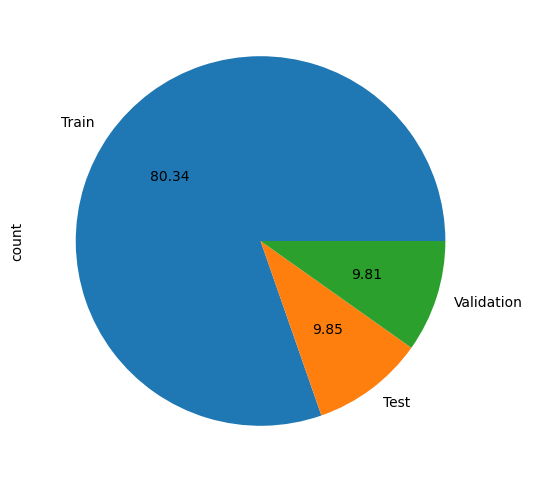

In [12]:
# Hacemos la separación en train, validation y test como se indica en el dataset 
df_train = full[full.partition == 0]
df_validation = full[full.partition == 1]
df_test = full[full.partition == 2]

print(df_train.shape, df_validation.shape, df_test.shape)
full.partition.value_counts().plot.pie(autopct='%.2f',figsize=(6,6), labels=['Train', 'Test', 'Validation'])

<Axes: ylabel='count'>

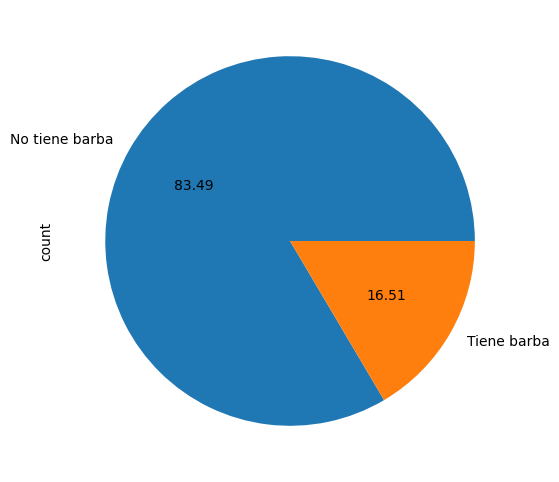

In [13]:
# Distribución en la totalidad del dataset
full.No_Beard.value_counts().plot.pie(autopct='%.2f',figsize=(6,6), labels=['No tiene barba', 'Tiene barba'])

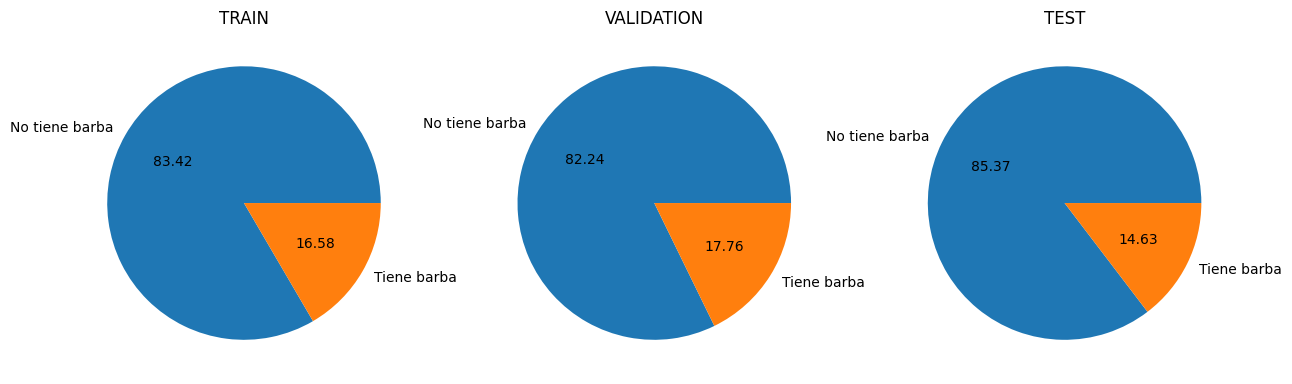

In [14]:
# Comparacion de la distribucion de 'No_Beard' en los tres subsets.
# Hacemos este análisis ya que no sabemos cómo hicieron la separación en los tres datasets,
# para ver si se mantiene la distribución de la variable de salida
fig, axis = plt.subplots(1,3, figsize=(15,10))
axis[0].pie(df_train.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[0].set_title('TRAIN')
axis[1].pie(df_validation.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[1].set_title('VALIDATION')
axis[2].pie(df_test.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[2].set_title('TEST')

plt.show()

In [16]:
# Creamos los datasets de keras
SIZE = 64 # Vamos a ir probando distintos tamaños... usaremos el mayor tamaño posible que se entrene en tiempo razonable

datagen = ImageDataGenerator(rescale=1./255)

train = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE,SIZE),
    class_mode='binary',
)

validation = datagen.flow_from_dataframe(
    dataframe=df_validation,
    directory=IMAGES_DIR,
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE,SIZE),
    class_mode='binary',
)

test = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE,SIZE),
    class_mode='binary',
)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


In [17]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(np.where(labels[i] == 1, 'Sin barba', 'Con Barba'))
        plt.axis("off")

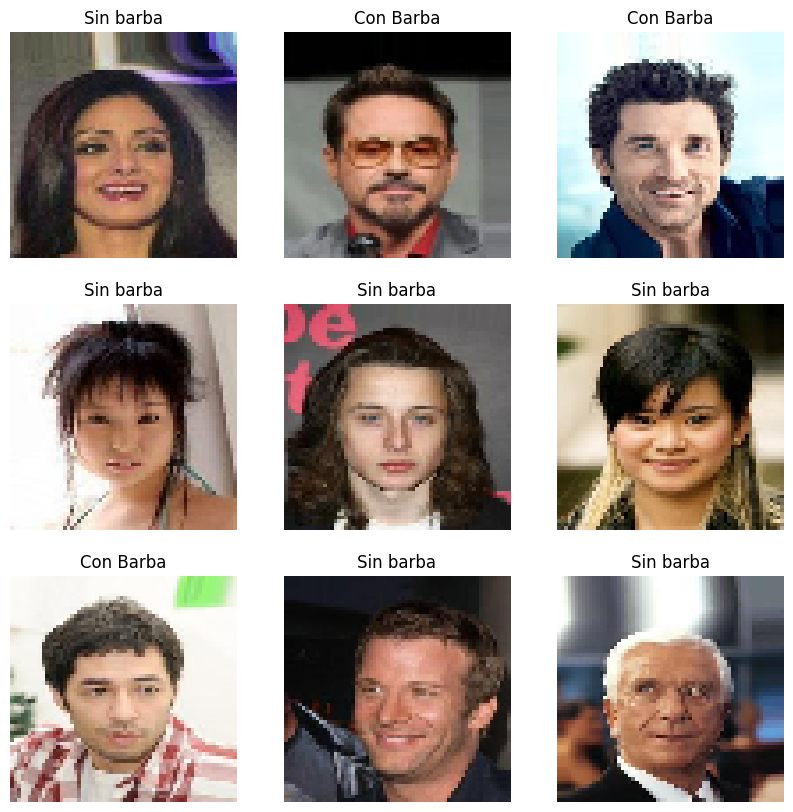

In [22]:
sample_images(test)